<a href="https://colab.research.google.com/github/shivam-01/IMDb-Reviews-Classifier/blob/master/IMDb_Reviews_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  IMDb Reviews Classification on Plain Text Data using Word Embeddings, LSTM, GRU and Conv1D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
# Import Tensorflow Datasets Service
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUDTINZ/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUDTINZ/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUDTINZ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Splitting train and test data into sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
# Hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the train and test data
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [ ]:
# Reverse the word index dictionary
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 10s 8ms/step - loss: 0.4908 - accuracy: 0.7448 - val_loss: 0.3447 - val_accuracy: 0.8498
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2305 - accuracy: 0.9132 - val_loss: 0.3832 - val_accuracy: 0.8350
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0803 - accuracy: 0.9803 - val_loss: 0.4588 - val_accuracy: 0.8286
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0188 - accuracy: 0.9980 - val_loss: 0.5389 - val_accuracy: 0.8290
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0047 - accuracy: 0.9997 - val_loss: 0.5961 - val_accuracy: 0.8288
Epoch 6/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6431 - val_accuracy: 0.8317
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 7.4464e-04 - accuracy: 1.0000 - val_loss: 0.6836 - val_accuracy: 0.8319
E

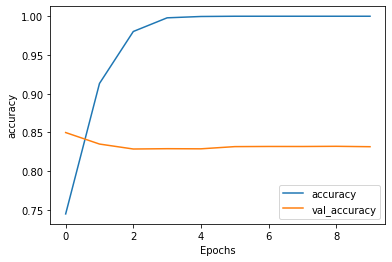

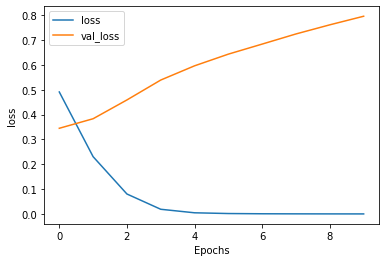

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Model Definition with LSTM

In [ ]:
# LSTM Model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 128)          41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 243,085
Trainable params: 243,085
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
num_epochs = 10
lstm_history = lstm_model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 126s 150ms/step - loss: 0.6271 - accuracy: 0.6425 - val_loss: 0.5722 - val_accuracy: 0.6709
Epoch 2/10
782/782 [==============================] - 116s 148ms/step - loss: 0.5697 - accuracy: 0.6999 - val_loss: 0.5626 - val_accuracy: 0.7229
Epoch 3/10
782/782 [==============================] - 116s 149ms/step - loss: 0.4201 - accuracy: 0.8176 - val_loss: 0.3735 - val_accuracy: 0.8352
Epoch 4/10
782/782 [==============================] - 116s 148ms/step - loss: 0.3059 - accuracy: 0.8768 - val_loss: 0.3895 - val_accuracy: 0.8385
Epoch 5/10
782/782 [==============================] - 116s 148ms/step - loss: 0.2521 - accuracy: 0.9040 - val_loss: 0.3767 - val_accuracy: 0.8412
Epoch 6/10
782/782 [==============================] - 116s 148ms/step - loss: 0.2121 - accuracy: 0.9234 - val_loss: 0.4097 - val_accuracy: 0.8348
Epoch 7/10
782/782 [==============================] - 116s 148ms/step - loss: 0.1765 - accuracy: 0.9372 - val_loss: 0.5041 -

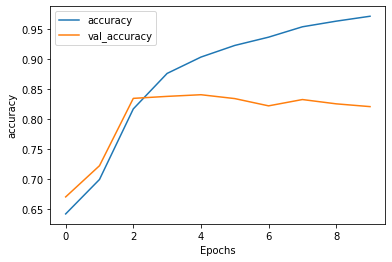

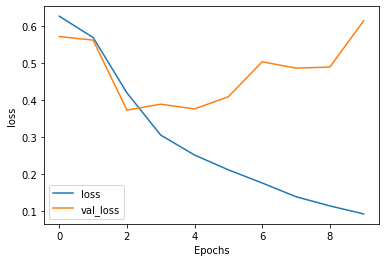

In [ ]:
plot_graphs(lstm_history, 'accuracy')
plot_graphs(lstm_history, 'loss')

# Model Definition with GRU

In [ ]:
# GRU Model
gru_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

gru_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
num_epochs = 10
gru_history = gru_model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 50s 60ms/step - loss: 0.5025 - accuracy: 0.7290 - val_loss: 0.3549 - val_accuracy: 0.8460
Epoch 2/10
782/782 [==============================] - 46s 58ms/step - loss: 0.2942 - accuracy: 0.8796 - val_loss: 0.3772 - val_accuracy: 0.8324
Epoch 3/10
782/782 [==============================] - 45s 58ms/step - loss: 0.2265 - accuracy: 0.9117 - val_loss: 0.3951 - val_accuracy: 0.8397
Epoch 4/10
782/782 [==============================] - 46s 58ms/step - loss: 0.1696 - accuracy: 0.9377 - val_loss: 0.4441 - val_accuracy: 0.8305
Epoch 5/10
782/782 [==============================] - 46s 58ms/step - loss: 0.1194 - accuracy: 0.9580 - val_loss: 0.5287 - val_accuracy: 0.8234
Epoch 6/10
782/782 [==============================] - 46s 58ms/step - loss: 0.0844 - accuracy: 0.9704 - val_loss: 0.6277 - val_accuracy: 0.8184
Epoch 7/10
782/782 [==============================] - 45s 58ms/step - loss: 0.0535 - accuracy: 0.9821 - val_loss: 0.7119 - val_accuracy:

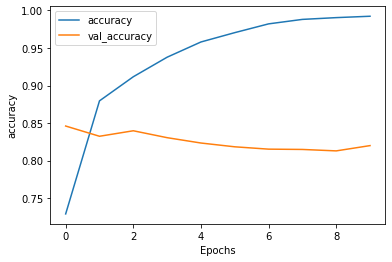

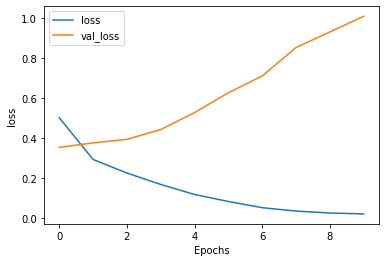

In [ ]:
plot_graphs(gru_history, 'accuracy')
plot_graphs(gru_history, 'loss')

# Model Definition with Conv1D

In [ ]:
# Conv1D Model
conv1D_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

conv1D_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

conv1D_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
num_epochs = 10
conv1D_history = conv1D_model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 34s 10ms/step - loss: 0.4407 - accuracy: 0.7950 - val_loss: 0.3459 - val_accuracy: 0.8495
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2791 - accuracy: 0.8860 - val_loss: 0.3550 - val_accuracy: 0.8460
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2270 - accuracy: 0.9097 - val_loss: 0.4101 - val_accuracy: 0.8266
Epoch 4/10
782/782 [==============================] - 7s 8ms/step - loss: 0.1858 - accuracy: 0.9315 - val_loss: 0.4249 - val_accuracy: 0.8323
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 0.1567 - accuracy: 0.9432 - val_loss: 0.4657 - val_accuracy: 0.8262
Epoch 6/10
782/782 [==============================] - 7s 10ms/step - loss: 0.1253 - accuracy: 0.9570 - val_loss: 0.5195 - val_accuracy: 0.8204
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1007 - accuracy: 0.9678 - val_loss: 0.5787 - val_accuracy: 0.8164
Ep

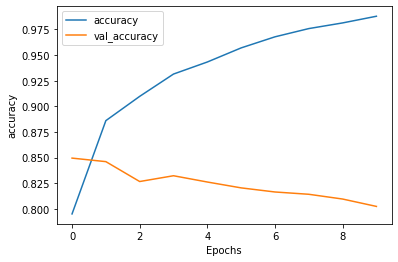

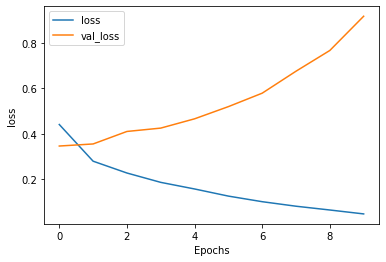

In [ ]:
plot_graphs(conv1D_history, 'accuracy')
plot_graphs(conv1D_history, 'loss')

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
# Generate the vector and metadata file for Visualisation
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download the vector and metadata file
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

# Go to https://projector.tensorflow.org/ and load both the files for visualisation.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)
padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating=trunc_type)
print(model.predict(padded))

[[11, 64, 102, 12, 7, 478, 1200]]
[[0.97056884]]
